In [11]:
import matplotlib.pyplot as plt
import pyspark.pandas as psp

from pyspark.sql.functions import date_format, format_number, sum, avg, col, row_number, dayofweek, round, desc, to_date
from pyspark.sql import SparkSession
from pyspark.sql.window import Window

In [12]:
spark = SparkSession.builder.appName("OrderAnalysis").getOrCreate()

# 1. Load the datasets into a PySpark DataFrames.
orders_df = spark.read.csv("data/orders.csv", header=True, inferSchema=True);
orders_df = orders_df.withColumn('OrderDate', to_date(col('OrderDate'), 'yyyy-MM-dd'))
# OrderID, CustomerID, ProductID, OrderQuantity, OrderDate, OrderDiscount
print(orders_df.dtypes);

products_df = spark.read.csv("data/products.csv", header=True, inferSchema=True);
print(products_df.dtypes);
# ProductID, UnitPrice,  Category

customers_df = spark.read.csv("data/customers.csv", header=True, inferSchema=True);
print(customers_df.dtypes);
# CustomerID, CustomerName, CustomerAddress

[('OrderID', 'int'), ('CustomerID', 'int'), ('ProductID', 'string'), ('OrderDate', 'date'), ('OrderQuantity', 'int'), ('OrderDiscount', 'int')]
[('ProductID', 'string'), ('ProductName', 'string'), ('Category', 'string'), ('UnitPrice', 'double')]
[('CustomerID', 'int'), ('CustomerName', 'string'), ('CustomerAddress', 'string')]


In [13]:
# 2. Calculate the total revenue generated by the company for each month and year. 
# Create a new DataFrame that shows the total revenue for each month-year 
# combination.

# Calculate total revenue by year and month
orders_sum_df = orders_df.join(products_df,"ProductID","inner");
# OrderID, CustomerID, OrderDate, ProductID, OrderQuantity, OrderDiscount,
# UnitPrice, Category

orders_sum_df = orders_sum_df.withColumn('order_revenue', 
                           round((orders_sum_df['UnitPrice'] * (100.0 - orders_sum_df['OrderDiscount']) / 100) *
                               orders_sum_df['OrderQuantity'], 2));


In [14]:
orders_keep_df = orders_sum_df;

orders_sum_df = orders_sum_df.drop('UnitPrice', 'OrderQuantity', 'OrderDiscount');
# OrderID, CustomerID, OrderDate, ProductID, Category, order_revenue
orders_sum_df = orders_sum_df.withColumn('OrderDate', to_date(col('OrderDate'), 'yyyy-MM-dd')) 
orders_sum_df = orders_sum_df.withColumn('year', date_format(col('OrderDate'), 'yyyy'))
orders_sum_df = orders_sum_df.withColumn('year-month', date_format(col('OrderDate'), 'yyyy-MM')).drop('OrderDate')
# OrderID, CustomerID, year, year-month, ProductID, Category, order_revenue"

In [15]:
year_month_revenue_df = orders_sum_df \
    .select(['year','year-month','order_revenue']) \
    .groupBy(['year','year-month']) \
    .agg(sum('order_revenue').alias('year_month_revenue')) \
    .orderBy(['year','year-month'])
# year,  year-month, year_month_revenue

year_revenue_df = year_month_revenue_df \
    .select(['year', 'year_month_revenue']) \
    .groupBy('year') \
    .agg(sum('year_month_revenue').alias('year_revenue')) \
    .orderBy('year')
# year, year_revenue

year_month_revenue_df.show()
year_revenue_df.show()

+----+----------+------------------+
|year|year-month|year_month_revenue|
+----+----------+------------------+
|2022|   2022-01|           2026.25|
|2022|   2022-02|            2500.0|
|2022|   2022-03|            2454.0|
|2022|   2022-04|            1693.0|
+----+----------+------------------+

+----+------------+
|year|year_revenue|
+----+------------+
|2022|     8673.25|
+----+------------+



In [16]:
# 3. Identify the top-selling product Category for each year.
# Create a new DataFrame that shows the top-selling Category for each year.

w = Window.partitionBy("year").orderBy(desc("order_revenue"))
year_top_category_df = orders_sum_df \
    .select(['year','Category','order_revenue']) \
    .withColumn("row",row_number().over(w))
# year, Category, order_revenue, row
year_top_category_df = year_top_category_df \
    .filter(col('row') == 1) \
    .orderBy(desc('year')) \
    .drop('row','order_revenue')
# year, Category

year_top_category_df.show()

+----+-----------+
|year|   Category|
+----+-----------+
|2022|Electronics|
+----+-----------+



In [17]:
# 4. Calculate the total revenue for each customer and identify the top 10 customers with the highest total revenue.

# OrderID, CustomerID, year, year-month, ProductID, Category, order_revenue"
customer_revenue_df  = orders_sum_df \
    .select(['CustomerID','order_revenue']) \
    .groupBy('CustomerID') \
    .agg(sum('order_revenue').alias('customer_revenue')) \
    .orderBy(desc('customer_revenue'))
customer_revenue_df.show()

+----------+----------------+
|CustomerID|customer_revenue|
+----------+----------------+
|       101|          2905.0|
|       104|          2600.0|
|       102|          1674.0|
|       103|         1456.25|
|       105|            38.0|
+----------+----------------+



In [18]:
# 5. Calculate the average discount percentage for each product Category.

category_average_discounts_df = orders_df \
    .select(['ProductID', 'OrderDiscount']) \
    .join(products_df,"ProductID","inner") \
    .select(['OrderDiscount','Category']) \
    .groupBy('Category') \
    .agg(avg('OrderDiscount').alias('category_average_discount')) \
    .withColumn('category_average_discount', round(col('category_average_discount'), 2)) \
    .withColumn('category_average_discount', format_number(col('category_average_discount'), 2)) \
    .withColumn('category_average_discount', col('category_average_discount').cast('int')) \
    .orderBy(desc('category_average_discount'))
category_average_discounts_df.show()

+-----------+-------------------------+
|   Category|category_average_discount|
+-----------+-------------------------+
|   Clothing|                       10|
|Electronics|                        8|
| Appliances|                        2|
+-----------+-------------------------+



In [19]:
# 6. Identify the day of the week with the highest total revenue for the company.

# OrderID, CustomerID, year, year-month, ProductID, Category, order_revenue"
print(orders_keep_df.dtypes)
print(products_df.dtypes)
orders_new_df = orders_keep_df.join(products_df,"ProductID","inner");

day_of_week_top_revenue_df = orders_new_df \
    .select(['OrderDate','order_revenue']) \
    .withColumn('day_of_week', dayofweek('OrderDate')) \
    .drop('OrderDate') \
    .groupBy('day_of_week') \
    .agg(sum('order_revenue').alias('day_of_week_revenue')) \
    .orderBy(desc('day_of_week_revenue'))
day_of_week_top_revenue_df.limit(1).show()

[('ProductID', 'string'), ('OrderID', 'int'), ('CustomerID', 'int'), ('OrderDate', 'date'), ('OrderQuantity', 'int'), ('OrderDiscount', 'int'), ('ProductName', 'string'), ('Category', 'string'), ('UnitPrice', 'double'), ('order_revenue', 'double')]
[('ProductID', 'string'), ('ProductName', 'string'), ('Category', 'string'), ('UnitPrice', 'double')]
+-----------+-------------------+
|day_of_week|day_of_week_revenue|
+-----------+-------------------+
|          1|             1959.0|
+-----------+-------------------+



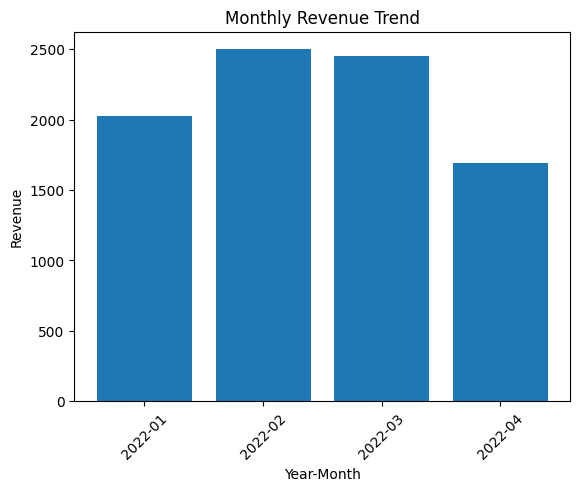

In [20]:
# 7. Create a visualization (e.g., bar chart or line chart) using a library like Matplotlib or Seaborn to visualize the monthly revenue trend over time.
# Convert the PySpark DataFrame to a Pandas DataFrame

pandas_df = year_month_revenue_df.toPandas()

# Create a bar chart using Matplotlib
plt.bar(pandas_df['year-month'], pandas_df['year_month_revenue'])
plt.xlabel('Year-Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue Trend')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.show()